- for download the using dataset: https://motchallenge.net/vis/MOT17-13-SDP/det/
- for download all dataset: https://motchallenge.net/data/MOT17/
- for article: https://arxiv.org/pdf/1603.00831.pdf

<img src="notes/boosting.png">
<img src="notes/boosting2.png">

In [1]:
import cv2
import os
from os.path import isfile, join
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import seaborn as sns

## 1-Read Images

In [2]:
pathInput = r"data/img1"
pathOut = "data/MOT17-13-SDP.mp4"

In [3]:
files = []
# first read files method
for f in os.listdir(pathInput):
    files.append(f)
files[0:5]

['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg']

In [4]:
# second read files method
# files = []
# files = [f for f in os.listdir(pathInput) if isfile(join(pathInput,f))] 
# files[0:5]

In [5]:
files[30]

'000031.jpg'

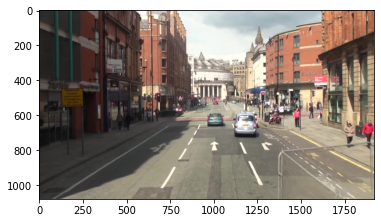

In [6]:
img = cv2.imread(pathInput + "\\" + files[30]) 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
plt.imshow(img)
plt.show()

## 2-Convert Images to Video

In [7]:
fps = 25
size = (1920, 1080)
out = cv2.VideoWriter(pathOut, cv2.VideoWriter_fourcc(*"MP4V"), fps, size, True)

In [8]:
for i in files: # i=file=image
    
    # print(i) # only controlling
    
    filename = pathInput + "\\" + i
    
    img = cv2.imread(filename)
    
    out.write(img)

print("converting done.")
out.release()

converting done.


## 3-Read Dataset

In [9]:
col_list = ["frame_number", "identity_number", "left", "top","width","height", "score", "class", "visibility"]

In [10]:
data = pd.read_csv("data/gt.txt", names = col_list) # en üste veri ismi ekler.
data.head()

,frame_number,identity_number,left,top,width,height,score,class,visibility
0,1,1,1376,485,37,28,0,11,1.0
1,2,1,1379,486,37,28,0,11,1.0
2,3,1,1382,487,38,29,0,11,1.0
3,4,1,1386,488,38,29,0,11,1.0
4,5,1,1389,490,38,29,0,11,1.0


<img src="notes/labels.png">

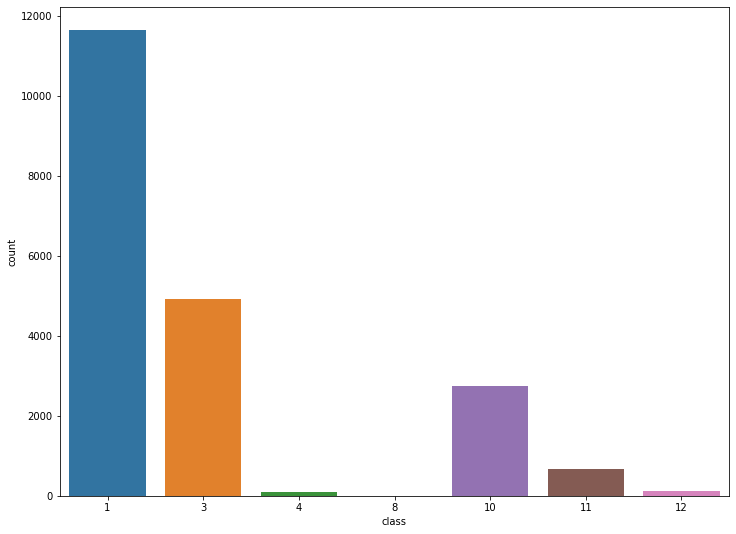

In [11]:
plt.figure(figsize=(12,9))
sns.countplot(x = data["class"])
plt.show()

In [12]:
pedestrian = data[data["class"] == 1]
car = data[data["class"] == 3]
bike = data[data["class"] == 4]

## 3-Basic Tracking

In [13]:
video_path = "data/MOT17-13-SDP.mp4"
cap = cv2.VideoCapture(video_path)

In [14]:
numberOfImage = np.max(data["frame_number"])
numberOfImage

750

In [15]:
id1 = 29
fps = 25
bound_box_list = [] # for storage rectangles

In [16]:
for i in range(numberOfImage-1):
    
    ret, frame = cap.read()
    
    if ret:
        
        frame = cv2.resize(frame, dsize=(960, 540))
        
        filter_id1 = np.logical_and(car["frame_number"] == i+1, car["identity_number"]==id1)
        
        if len(car[filter_id1]) != 0: # uzunluğu boş değilse
            
            x = int(car[filter_id1].left.values[0]/2) # x=left/2
            y = int(car[filter_id1].top.values[0]/2)
            w = int(car[filter_id1].width.values[0]/2)
            h = int(car[filter_id1].height.values[0]/2)
            
            cv2.rectangle(img = frame, pt1 = (x,y), pt2 = (x+w,y+h), color = (0,255,0), thickness = 2)
            cv2.circle(frame, center = (int(x+w/2), int(y+h/2)), radius = 2, color = (0,0,255), thickness= -1)
            
            # frame, x, y, genis, yuksek, center_x, center_y
            bound_box_list.append([i, x,y,w,h, int(x+w/2), int(y+h/2)])
            
        cv2.putText(frame, "Frame num:" + str(i+1), (10,30), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,1,(0,0,255), 2)
        cv2.imshow("frame", frame)

        if cv2.waitKey(1) == ord("q"): break
    else: break

cap.release()
cv2.destroyAllWindows()        

In [17]:
df = pd.DataFrame(bound_box_list, columns = ["frame_no", "x", "y", "w", "h", "center_x", "center_y"])
      
df.to_csv("data/gt_new.txt", index = False)

## 4-Tracking Algorithms

In [18]:
print(cv2.__version__)

4.5.5


In [19]:
OPENCV_OBJECT_TRACKERS = {"csrt"      : cv2.legacy.TrackerCSRT_create,
		                  "kcf"       : cv2.legacy.TrackerKCF_create,
		                  "boosting"  : cv2.legacy.TrackerBoosting_create,
		                  "mil"       : cv2.legacy.TrackerMIL_create,
		                  "tld"       : cv2.legacy.TrackerTLD_create,
		                  "medianflow": cv2.legacy.TrackerMedianFlow_create,
		                  "mosse"     : cv2.legacy.TrackerMOSSE_create}

In [20]:
tracker_name = "boosting"
tracker = OPENCV_OBJECT_TRACKERS[tracker_name]()
print("Tracker:", tracker_name)

Tracker: boosting


In [21]:
gt = pd.read_csv("data/gt_new.txt")
gt.head()

,frame_no,x,y,w,h,center_x,center_y
0,0,477,274,40,31,497,289
1,1,477,272,41,31,497,287
2,2,478,273,41,32,498,289
3,3,478,274,41,32,498,290
4,4,479,275,42,32,500,291


In [22]:
video_path = "data/MOT17-13-SDP.mp4"
cap = cv2.VideoCapture(video_path)

In [23]:
# Parameters
initBB = None # rectangle box
fps = 25
frame_number = []
f = 0
success_track_frame_success = 0
track_list = []
start_time = time.time() 

In [24]:
while True:
    
    time.sleep(0.01)
    
    ret, frame = cap.read()
    
    if ret:
        
        frame = cv2.resize(frame, dsize = (960,540))
        (H, W) = frame.shape[:2]
        
        # gt
        car_gt = gt[gt.frame_no == f]
        if len(car_gt) != 0:
            x = car_gt.x.values[0]
            y = car_gt.y.values[0]
            w = car_gt.w.values[0]
            h = car_gt.h.values[0]
            
            center_x = car_gt.center_x.values[0]
            center_y = car_gt.center_y.values[0]
            
            cv2.rectangle(frame, (x,y), (x+w, y+h),(0,255,0),2)
            cv2.circle(frame, (center_x, center_y), 2,(0,0,255),-1) # -1=filled
            
        # box
        if initBB is not None:
            
            (success, box) = tracker.update(frame)
            
            if f<=np.max(gt.frame_no):
                (x,y,w,h) = [int(i) for i in box]
                
                cv2.rectangle(frame, (x,y),(x+w,y+h),(0,0,255),2)
                success_track_frame_success = success_track_frame_success + 1
                track_center_x = int(x+w/2)
                track_center_y = int(y+h/2)
                track_list.append([f,track_center_x,track_center_y])
            
            info = [("Tracker",tracker_name),
                    ("Success", "Yes" if success else "No")]
            
            for (i,(o,p)) in enumerate(info):
                text = "{}: {} ".format(o,p)
                cv2.putText(frame, text, (10, H -(i*20)-10), cv2.FONT_HERSHEY_SIMPLEX,0.6, (0,0,255),2)
            
        cv2.putText(frame,"Frame Num: "+str(f), (10,30),cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255),2)
        cv2.imshow("frame",frame)    
        # key
        key = cv2.waitKey(1)
           
        if key == ord("t"):
            initBB = cv2.selectROI("Frame", frame, fromCenter = False) # takip etmek istenilen nesne/bölge
            
            tracker.init(frame, initBB)
            
        elif key == ord("q"):break
        
        
        # frame
        frame_number.append(f)
        f = f + 1 # bir sonraki resme geçer
        
    else: break
    
cap.release()
cv2.destroyAllWindows()

stop_time = time.time()
time_diff = stop_time - start_time    

In [25]:
# degerlendirme
track_df = pd.DataFrame(track_list, columns =["frame_no","center_x","center_y"])

Tracking method:  <legacy_TrackerBoosting 00000140D9E19F10>
Time:  14.787434816360474
Number of frame to track (gt):  451
Number of frame to track (track success):  53


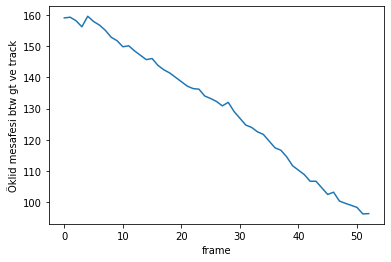

Toplam hata:  6894.379798691441


In [26]:
if len(track_df) != 0:
    print("Tracking method: ",tracker)
    print("Time: ",time_diff)
    print("Number of frame to track (gt): ",len(gt))
    print("Number of frame to track (track success): ",success_track_frame_success)
    
    track_df_frame = track_df.frame_no
    
    gt_center_x = gt.center_x[track_df_frame].values
    gt_center_y = gt.center_y[track_df_frame].values
    
    track_df_center_x = track_df.center_x.values
    track_df_center_y = track_df.center_y.values
    
    plt.plot(np.sqrt((gt_center_x-track_df_center_x)**2 + (gt_center_y-track_df_center_y)**2 ))
    plt.xlabel("frame")
    plt.ylabel("Öklid mesafesi btw gt ve track")
    plt.show()
    error = np.sum(np.sqrt((gt_center_x-track_df_center_x)**2 + (gt_center_y-track_df_center_y)**2 ))
    print("Toplam hata: ",error)